In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from joblib import dump, load
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [85]:
english_words = set(words.words())  # load nltk dictionary

In [86]:
# load dataset
df = pd.read_csv('cyberbullying.csv')

# clean texts
df['text'] = df['text'].apply(lambda text: ' '.join([token for token in word_tokenize(text.lower()) if token in english_words]))

# convert labels into numeric
df['label'] = df['label'].apply(lambda x: 0 if x == "not_cyberbullying" else 1)

df.head(10)

,text,label
0,any real is this happen,1
1,i did even mention but the us is far from the ...,0
2,the only thing i wish i wish a would,1
3,you are not of people,1
4,and yet the want to do just that the and belie...,1
5,wait its so this got rabies,1
6,a voting machine error in new jersey the outco...,0
7,now in president the situation is better for b...,1
8,agreed i used to tell my history this my birth...,1
9,linked in an you on a roll with your career in...,0


In [87]:
# count all positive (non bullying) and negative (bullying) texts
positive = df[df['label'] == 0]
negative = df[df['label'] == 1]

print(f"Positive: {len(positive)}")
print(f"Negative: {len(negative)}")

Positive: 50000
Negative: 49990


In [88]:
negative['count'] = negative['text'].apply(lambda text: len(text.split()))  # count the number of words per text
negative = negative.sort_values(by='count', ascending=False)  # sort by the number of words per text
negative = negative.iloc[:20000]  # take only the first 20000 relevant texts

negative.head(10)

C:\Users\Nathanael Almazan\AppData\Local\Temp\ipykernel_25220\289793681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative['count'] = negative['text'].apply(lambda text: len(text.split()))


,text,label,count
31047,and yet god was able to meet their needs radic...,1,82
12256,i know we re a terrible team i m not a delusio...,1,66
9979,honestly this job is gon na be a lot it s gon ...,1,65
31989,i want to be who they wan na be and don t let ...,1,64
82710,he s not my he s not my he s not my he s not m...,1,60
71867,i know there is nothing else in to care about ...,1,60
36907,so he can rape if you were a rapist and you we...,1,60
85825,i want you to be who you wan na be and love wh...,1,60
20364,i want to believe and trust the process and do...,1,60
21758,i m literally so dumb like whenever i am not h...,1,60


In [89]:
positive['count'] = positive['text'].apply(lambda x: len(x.split()))  # count the number of words per text
positive = positive.sort_values(by='count', ascending=False)  # sort by the number of words per text
positive = positive.iloc[:20000]  # sort by the number of words per text

positive.head(10)

C:\Users\Nathanael Almazan\AppData\Local\Temp\ipykernel_25220\3252185518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive['count'] = positive['text'].apply(lambda x: len(x.split()))


,text,label,count
3405,oh rach ten long and every day there are still...,0,49
5989,one thing we can all agree on is this life t a...,0,48
30999,hi good morning how s your sleep last night i ...,0,48
81286,at visibility in fog is making difficult in ou...,0,48
41129,it amazing to hear that are going well so far ...,0,47
82931,i can be hard on myself i tend to respond to s...,0,47
52017,soul of love soul of peace let your heart spea...,0,47
49473,so happy to have you back i was lucky enough t...,0,46
43535,making time for an activity you enjoy is a gre...,0,46
38667,i love how was able to her nana speaking about...,0,46


In [90]:
subset = pd.concat([positive, negative])
subset = subset.drop(columns=['count'])

# shuffle dataset
subset = subset.sample(frac=1).reset_index(drop=True)

subset.head(10)

,text,label
0,third they what a bad bitch is to him his resp...,1
1,there is another prayer you say after by the p...,1
2,where your compassion for this poor woman let ...,1
3,no now pay the i do pay musk a dime because i ...,0
4,people are like they sparkle and shine when th...,0
5,i doubt if this one is a but if you are eventu...,1
6,one for the money two for the show i never was...,0
7,do use what going to push away the or else the...,0
8,thanks for finding ways to screw digital today...,0
9,could someone link me to that defeat money mak...,0


In [2]:
sia = SentimentIntensityAnalyzer()  # load sentiment analyzer

# convert text into vectors
def text_to_vector(text: str, label: int) -> np.ndarray:
    sentiment = sia.polarity_scores(text)
    return np.array([sentiment['neg'], sentiment['neu'], sentiment['pos'], label], dtype=np.float64)

In [92]:
vectors = np.array([text_to_vector(row['text'], row['label']) for _, row in subset.iterrows()])
vectors.shape

(40000, 4)

In [93]:
non_zero = vectors[~np.all(vectors == 0, axis=1)]
positive = non_zero[(non_zero[:, 2] > 0.6) & (non_zero[:, 3] == 0)]
negative = non_zero[(non_zero[:, 0] > 0.6) & (non_zero[:, 3] == 1)]

print(positive.shape)
print(negative.shape)

(58, 4)
(20, 4)


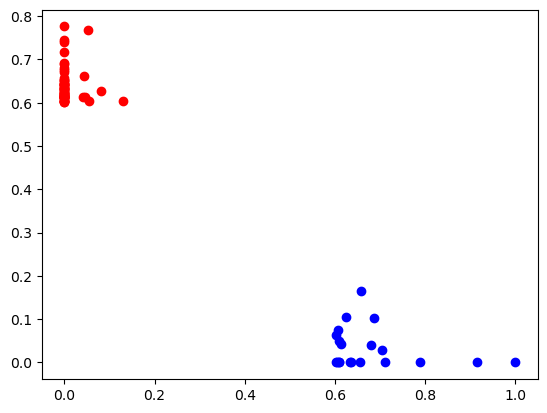

In [94]:
plt.scatter(x=positive[:, 0], y=positive[:, 2], color="red")
plt.scatter(x=negative[:, 0], y=negative[:, 2], color="blue")
plt.show()

In [95]:
X_train, X_test, y_train, y_test = train_test_split(vectors[:, :-1], vectors[:, -1], test_size=0.30, random_state=42)

print('train:', y_train.shape)
print('test:', y_test.shape)

train: (28000,)
test: (12000,)


In [96]:
svm = SVC(kernel="rbf", gamma="scale")
svm.fit(X_train, y_train)

y_pred = svm.predict(X_train)

accuracy_score(y_train, y_pred)

0.7163571428571428

In [110]:
dump(svm, 'svm.joblib') 

['svm.joblib']

In [97]:
y_pred = svm.predict(X_test)

accuracy_score(y_test, y_pred)

0.721

In [17]:
svm: SVC = load('svm.joblib')

In [18]:
vector = text_to_vector("Can they just send Kat and Andre home anyway because they're rude and annoying. Although, they are still my dearest friends.", 1)
vector

array([0.194, 0.578, 0.228, 1.   ])

In [19]:
y_pred = svm.predict([vector[:-1]])
y_pred

array([1.])